C:\Users\brind\AppData\Local\Temp\ipykernel_101544\2963930074.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


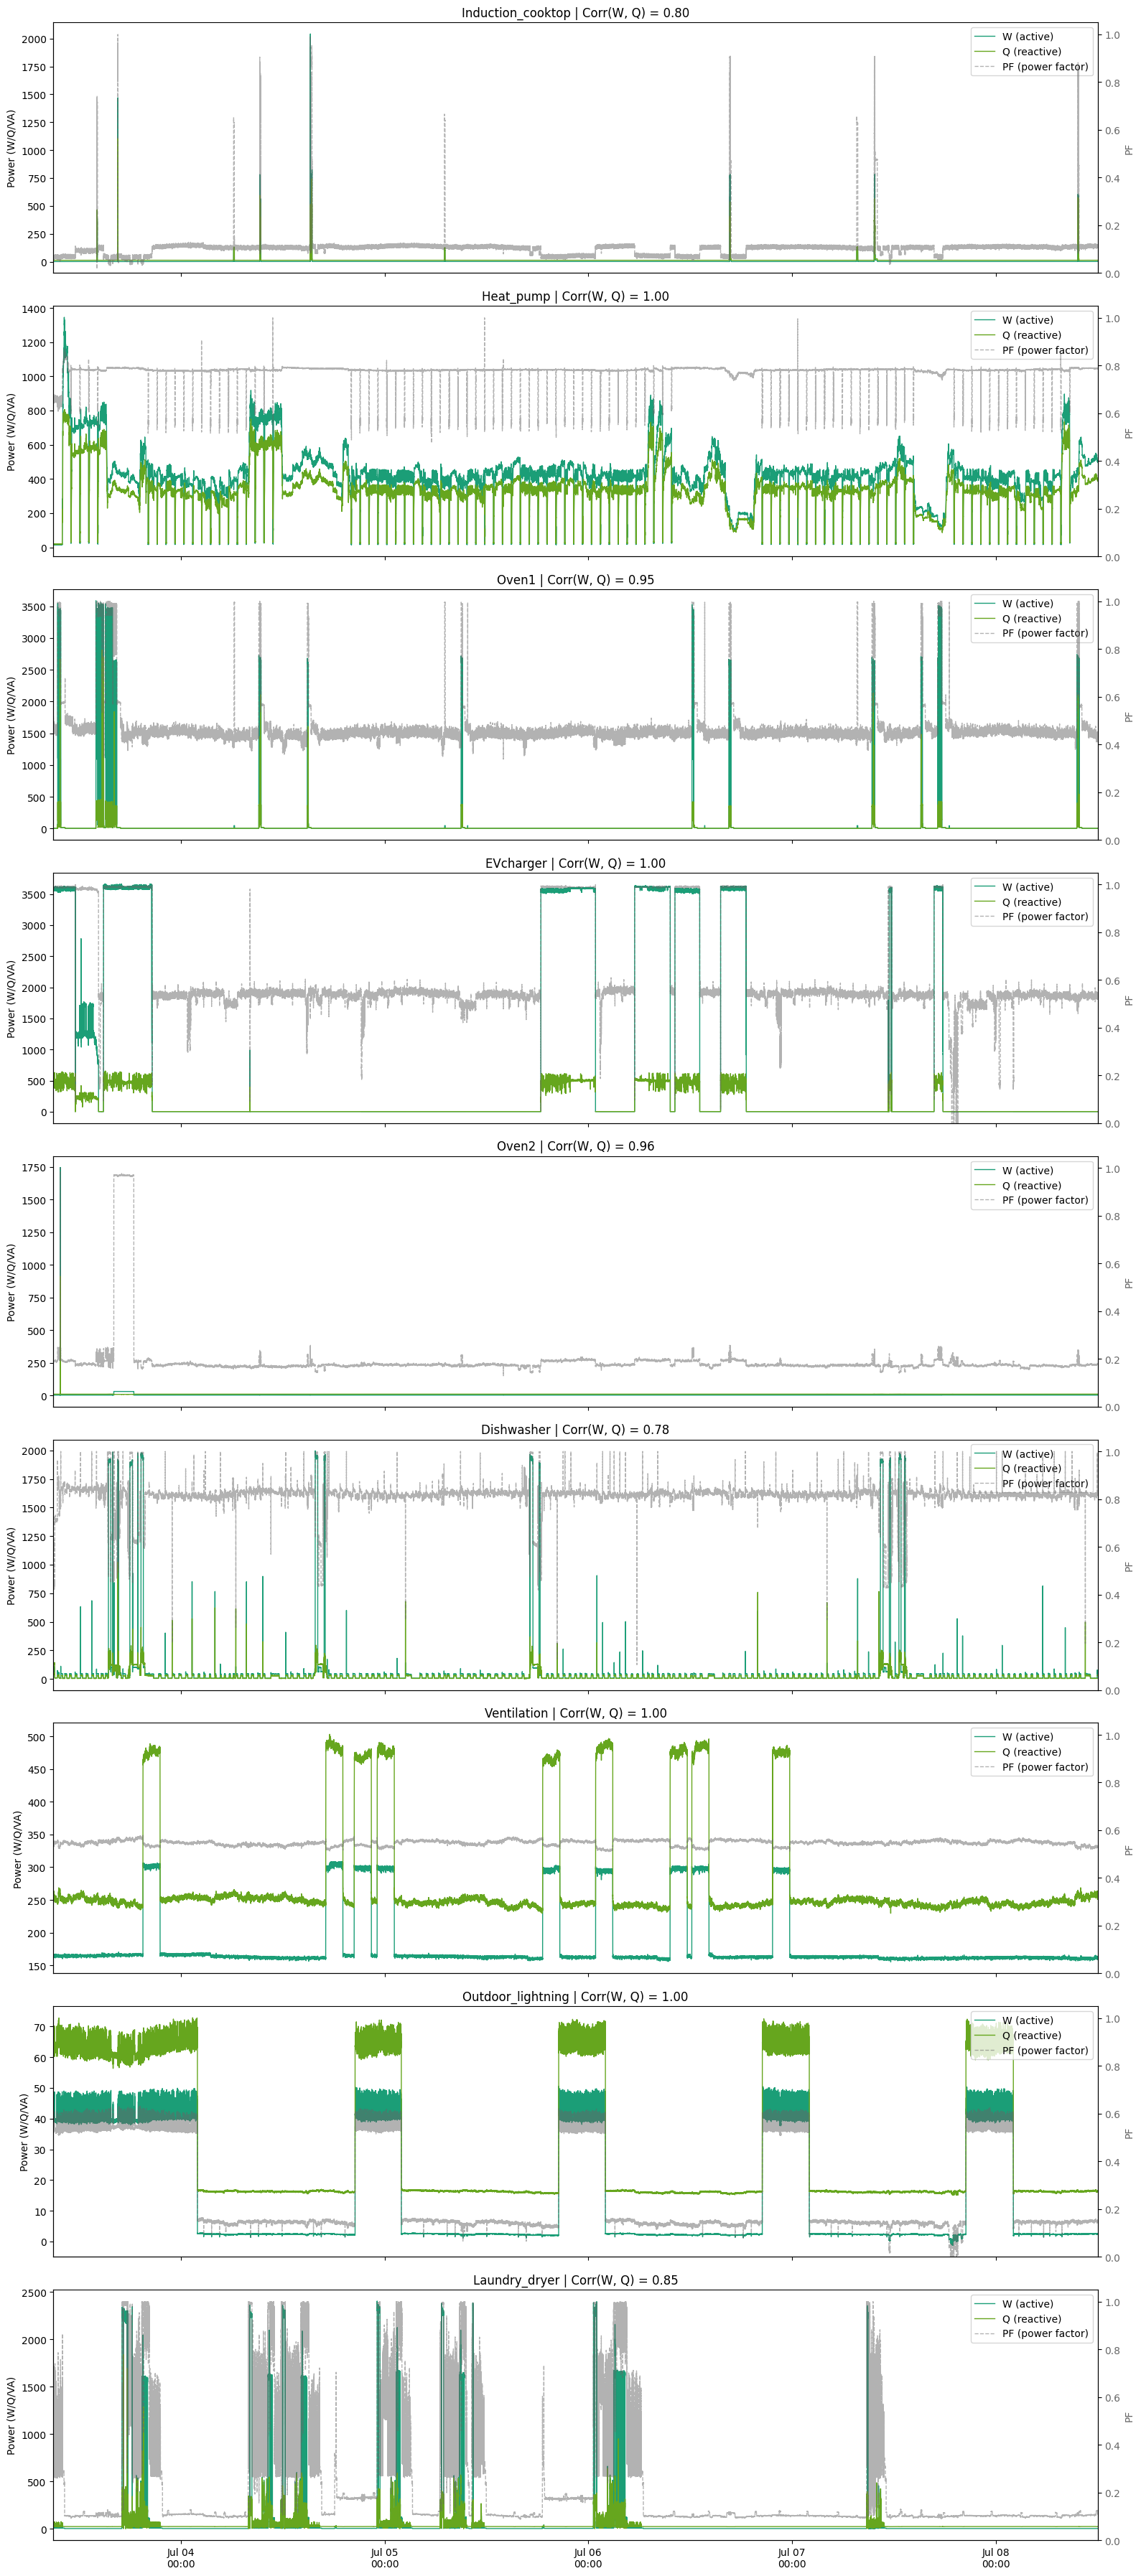

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors


def plot_power_metrics(
    df: pd.DataFrame,
    channel_label: list[str],
    plot_metrics: list[str] = ["W", "Q", "VA"],
    plot_pf: bool = True,
    xlim_start=None,
    xlim_end=None,
    cmap_name="tab10"  # <-- NEW: user-selected colormap
):
    # Create colormap from selected name
    cmap = cm.get_cmap(cmap_name)
    all_metrics = plot_metrics + (["PF"] if plot_pf else [])
    
    # Dynamically assign colors from colormap
    color_map = {
        metric: mcolors.to_hex(cmap(i / max(len(all_metrics) - 1, 1)))
        for i, metric in enumerate(all_metrics)
    }

    label_map = {
        "W": "W (active)",
        "Q": "Q (reactive)",
        "VA": "VA (apparent)",
        "PF": "PF (power factor)"
    }


    # Ensure datetime format
    if not pd.api.types.is_datetime64_any_dtype(df["timestamp"]):
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")

    # Convert and apply time range filter
    if xlim_start:
        xlim_start = pd.to_datetime(xlim_start)
    if xlim_end:
        xlim_end = pd.to_datetime(xlim_end)
    
    mask = pd.Series(True, index=df.index)
    if xlim_start:
        mask &= df["timestamp"] >= xlim_start
    if xlim_end:
        mask &= df["timestamp"] <= xlim_end
    df_filtered = df.loc[mask]

    # Set up subplots
    fig, axs = plt.subplots(len(channel_label), 1, figsize=(16, 4 * len(channel_label)), sharex=True)


    for i, device in enumerate(channel_label):
        ax = axs[i]

        # Plot selected metrics
        for metric in plot_metrics:
            col = f"{device}_{metric}"
            if col in df_filtered.columns:
                ax.plot(df_filtered["timestamp"], df_filtered[col],
                        label=label_map[metric],
                        color=color_map[metric],
                        linewidth=1)

        # Compute correlation in the filtered range
        w_col = f"{device}_W"
        q_col = f"{device}_Q"
        if w_col in df_filtered.columns and q_col in df_filtered.columns:
            corr_df = df_filtered[[w_col, q_col]].dropna()
            corr = corr_df.corr().iloc[0, 1] if not corr_df.empty else float('nan')
            ax.set_title(f"{device} | Corr(W, Q) = {corr:.2f}")
        else:
            ax.set_title(f"{device}")

        ax.set_ylabel("Power (W/Q/VA)")

        # Plot PF on right axis
        if plot_pf:
            pf_col = f"{device}_PF"
            if pf_col in df_filtered.columns:
                ax2 = ax.twinx()
                ax2.plot(df_filtered["timestamp"], df_filtered[pf_col],
                         label=label_map["PF"],
                         color=color_map["PF"],
                         linestyle="dashed",
                         linewidth=1,
                         alpha=0.5)
                ax2.set_ylim(0, 1.05)
                ax2.set_ylabel("PF", color=color_map["PF"])
                ax2.tick_params(axis="y", labelcolor=color_map["PF"])
                # KEEP right spine visible if PF is plotted
                ax2.spines["top"].set_visible(False)
                ax2.spines["right"].set_visible(True)  # <--- make it visible
        else:
            # Hide right axis completely if PF not plotted
            ax2 = ax.twinx()
            ax2.set_yticks([])
            ax2.spines["top"].set_visible(False)
            ax2.spines["right"].set_visible(False)

        # Merge legends
        lines, labels = ax.get_legend_handles_labels()
        if plot_pf and 'ax2' in locals():
            lines2, labels2 = ax2.get_legend_handles_labels()
            lines += lines2
            labels += labels2
        ax.legend(lines, labels, loc="upper right")

        # Set x-limits if provided
        if xlim_start and xlim_end:
            ax.set_xlim(xlim_start, xlim_end)

    # Format x-axis
    axs[-1].xaxis.set_major_locator(mdates.AutoDateLocator())
    axs[-1].xaxis.set_major_formatter(mdates.DateFormatter("%b %d\n%H:%M"))
    # fig.text(0.04, 0.5, 'Power (W / VA / Q)', va='center', rotation='vertical')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# List of devices (must match df column prefixes)
channel_label = [
    'Induction_cooktop', 'Heat_pump', 'Oven1', 'EVcharger', 'Oven2',
    'Dishwasher', 'Ventilation', 'Outdoor_lightning', 'Laundry_dryer'
]


df = pd.read_hdf("emonesp_data.h5", key="power")
# Plot only W and Q, no PF
plot_power_metrics(
    df,
    channel_label=[
        'Induction_cooktop', 'Heat_pump', 'Oven1', 'EVcharger', 'Oven2',
        'Dishwasher', 'Ventilation', 'Outdoor_lightning', 'Laundry_dryer'
    ],
    plot_metrics=["W", "Q"],
    plot_pf=True,
    xlim_start="2025-07-03 09:00",
    xlim_end="2025-07-08 12:00",
    cmap_name='Dark2'
)